# 4. Dask (numpy) arrays

As mentioned before, there are other solutions to perform perform parallel computing in Python. However Dask offers an crucial feature not present in other libraries: a built-in parallelized implemtation of large parts of the popular libraries Numpy and Pandas. In other terms, no need to systematically use ```delayed``` or think how to optimize a function, Dask has already done it for you!

Here we will first explore possibilities offered by dask-arrays, the equivalent of numpy arrays. As usual, we first create our cluster:

In [1]:
from dask.distributed import Client

client = Client()#Client("tcp://127.0.0.1:63517")
client

<Client: 'tcp://127.0.0.1:49828' processes=4 threads=4, memory=17.18 GB>

## Dask-arrays are numpy-delayed arrays

The equivalent of the numpy import is the dask.array import:

In [2]:
import dask.array as da
import numpy as np

A great feature of ```dask.array``` is that it mirror very closely the Numpy API, so if you are familiar with the latter, you should have no problem with dask.

For example let's create an array of random numbers and check that they behave the same way:

In [3]:
nprand = np.random.randint(0,100, (4,5))

In [4]:
darand  = da.random.randint(0,100, (4,5))

In [5]:
nprand.shape

(4, 5)

In [6]:
darand.shape

(4, 5)

Let's look that the arrays directly:

In [7]:
nprand

array([[51,  9, 13, 16, 58],
       [65, 74, 33, 35, 18],
       [21, 73, 72, 53, 13],
       [63, 29, 90, 11, 77]])

In [8]:
darand

dask.array<randint, shape=(4, 5), dtype=int64, chunksize=(4, 5), chunktype=numpy.ndarray>

Here we see already a difference. Numpy just shows the matrix, while dask shows us a much richer output, including size, type, dimensionality etc.

But do the ```darand``` values exist anywhere ? Let's check that we can find the maximum in the array:

In [9]:
darand.max()

dask.array<amax-aggregate, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>

Again, we get some info but no values. In fact, as with ```delayed``` before, the values have not been computed yet!

The logic is the same as with delayed. Any time we actually want a result we can call the ```compute``` method:

In [10]:
darand.max().compute()

92

There could also be intermediate steps:

In [11]:
myval = 10*darand.max()

In [12]:
myval.compute()

920

Dask re-implements many standard array creation functions, including ```zeros()```, ```ones()``` and many of the ```np.random``` module.

However one can also create arrays directly from a numpy array:

In [13]:
da_array = da.from_array(np.ones((5,8)))

In [14]:
da_array

dask.array<array, shape=(5, 8), dtype=float64, chunksize=(5, 8), chunktype=numpy.ndarray>

## Dask-arrays are distributed

Let's create a larger array and see how it is handled by Dask and compare it with Numpy:

In [15]:
large_nparray = np.random.randint(0,100,(10000,1000,100))

In [16]:
myarray = da.random.randint(0,100,(10000,1000,100))

In [17]:
myarray

dask.array<randint, shape=(10000, 1000, 100), dtype=int64, chunksize=(400, 250, 100), chunktype=numpy.ndarray>

First, notice how the array visualisation is helpful! Second, note that we have information about "chunks". When handling larger objects, Dasks automatically breaks them into chunks that can be generated or operated on by different workers in a parallel way. We can compute the mean of this array and observe what happens:

In [18]:
mean = myarray.mean()

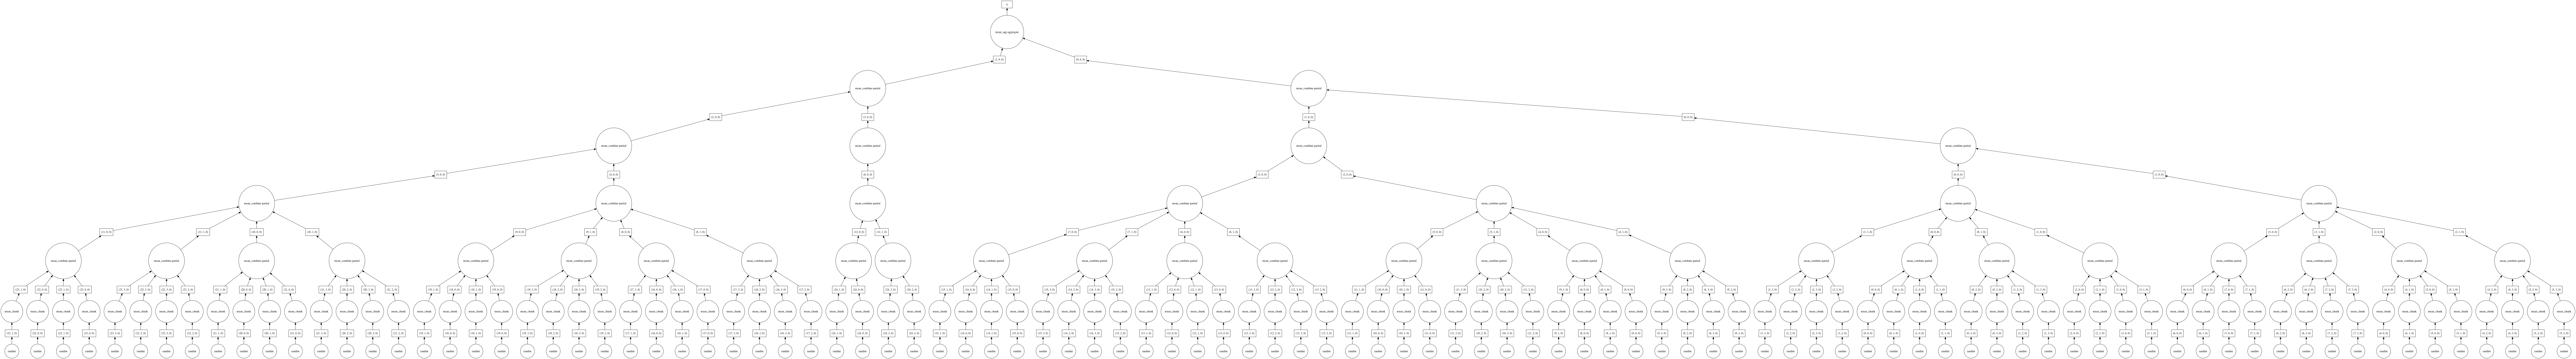

In [19]:
mean.visualize()

In [20]:
mean.compute()

49.500024045

## Slicing like in Numpy

One of the main feature of numpy array is the possibility to slice and index them. Great news: dask arrays behave exactly in the same way for most "regular" cases (e.g. it doesn't implement slicing with multiple lists). Let's see how it works:

In [21]:
myarray = da.random.random((5000,5000))

In [22]:
myarray

dask.array<random_sample, shape=(5000, 5000), dtype=float64, chunksize=(2500, 2500), chunktype=numpy.ndarray>

For example we can slice the array:

In [23]:
sliced_array = myarray[::2,:]

In [24]:
sliced_array

dask.array<getitem, shape=(2500, 5000), dtype=float64, chunksize=(1250, 2500), chunktype=numpy.ndarray>

Or we can use logical indexing. First we create a logical array:

In [25]:
logical_array = myarray > 0.5

In [26]:
logical_array

dask.array<gt, shape=(5000, 5000), dtype=bool, chunksize=(2500, 2500), chunktype=numpy.ndarray>

And then use it for logical indexing:

In [27]:
extracted_values = myarray[logical_array]

In [28]:
extracted_values

dask.array<getitem, shape=(nan,), dtype=float64, chunksize=(nan,), chunktype=numpy.ndarray>

Of course here for example we don't know the size of the resulting length. This is a typical case where any downstream parallelization becomes difficult as chunks of the array cannot be distributed. However we can get the result:

In [29]:
values = extracted_values.compute()

In [30]:
values

array([0.70391801, 0.77259917, 0.62909038, ..., 0.55682599, 0.72369627,
       0.81818577])

## Numpy functions just work!

An extremely useful features of Dask is that whenever you are handling a dask-array you can apply most of the Numpy funtions to it and it remains a dask-array, **i.e. it gets integrated in the task graph**. For example:

In [31]:
cos_array = np.cos(myarray)

In [32]:
cos_array

dask.array<cos, shape=(5000, 5000), dtype=float64, chunksize=(2500, 2500), chunktype=numpy.ndarray>

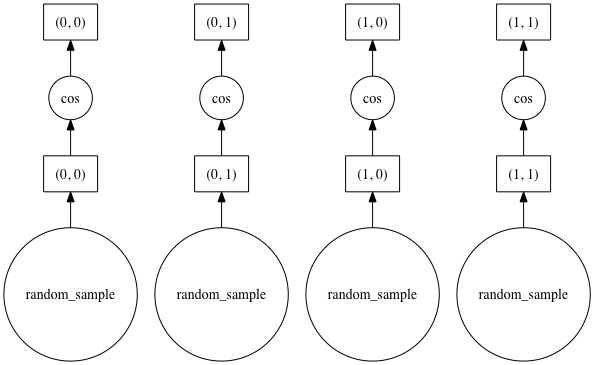

In [33]:
cos_array.visualize()

Dask also re-implements many numpy functions internally so that they are accessible as methods of the dask-arrays:

In [34]:
proj = myarray.sum(axis = 0)

In [35]:
proj

dask.array<sum-aggregate, shape=(5000,), dtype=float64, chunksize=(2500,), chunktype=numpy.ndarray>

The great advantage of dask-arrays is that functions have been optimized in order to make the task-graph very efficient. For example this simple calculation produces already a quite complex task graph. If handling large "out-of-RAM" array with numpy, one would have to break up the large array and be very smart about how to process each task.

In [36]:
newda = myarray + da.transpose(myarray)

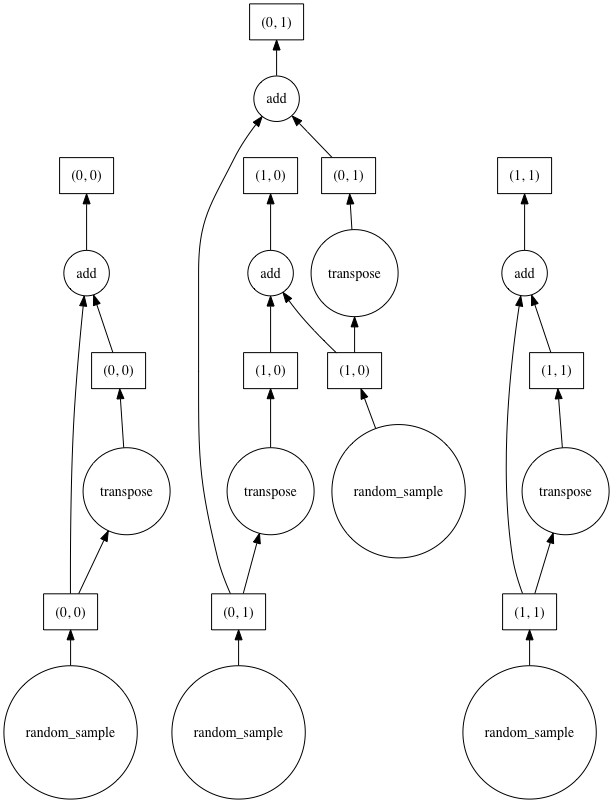

In [37]:
newda.visualize()

This is already quite complicated, but it can become much more complicated very quickly.

In [38]:
newda = da.dot(myarray, myarray + da.transpose(myarray))

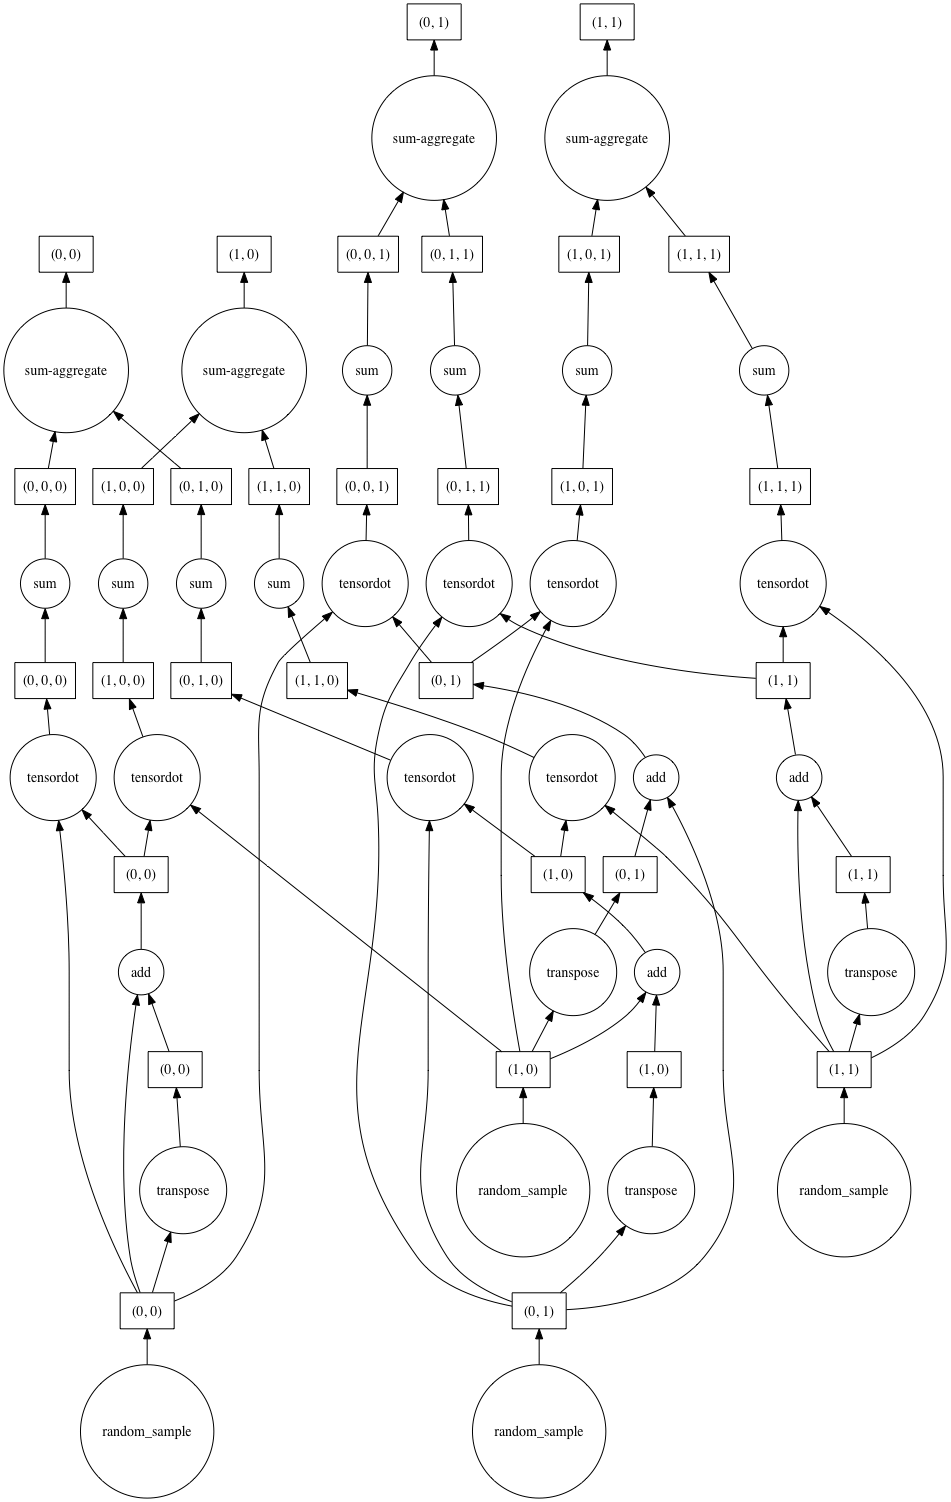

In [39]:
newda.visualize()

In [40]:
%%time
computed_array = newda.compute();

CPU times: user 505 ms, sys: 499 ms, total: 1 s
Wall time: 5.21 s


In [41]:
myarray2 = np.random.random((5000,5000))

In [42]:
%%time
newnp = np.dot(myarray2, myarray2 + np.transpose(myarray2))

CPU times: user 11 s, sys: 349 ms, total: 11.3 s
Wall time: 3.85 s


We see here that for a reasonably sized array, the overhead time needed to push data between processes makes Dask slower than basic Numpy because Numpy already efficiently uses multi-threading on a laptop. However on a cluster with many more cores, this won't necessarily be true. Finally, also note that Dask scales nicely, so that it still works for very large arrays that definitely don't hold into RAM:

In [43]:
myarray = da.random.random((20000,20000))

In [44]:
newda = da.dot(myarray, myarray + da.transpose(myarray))

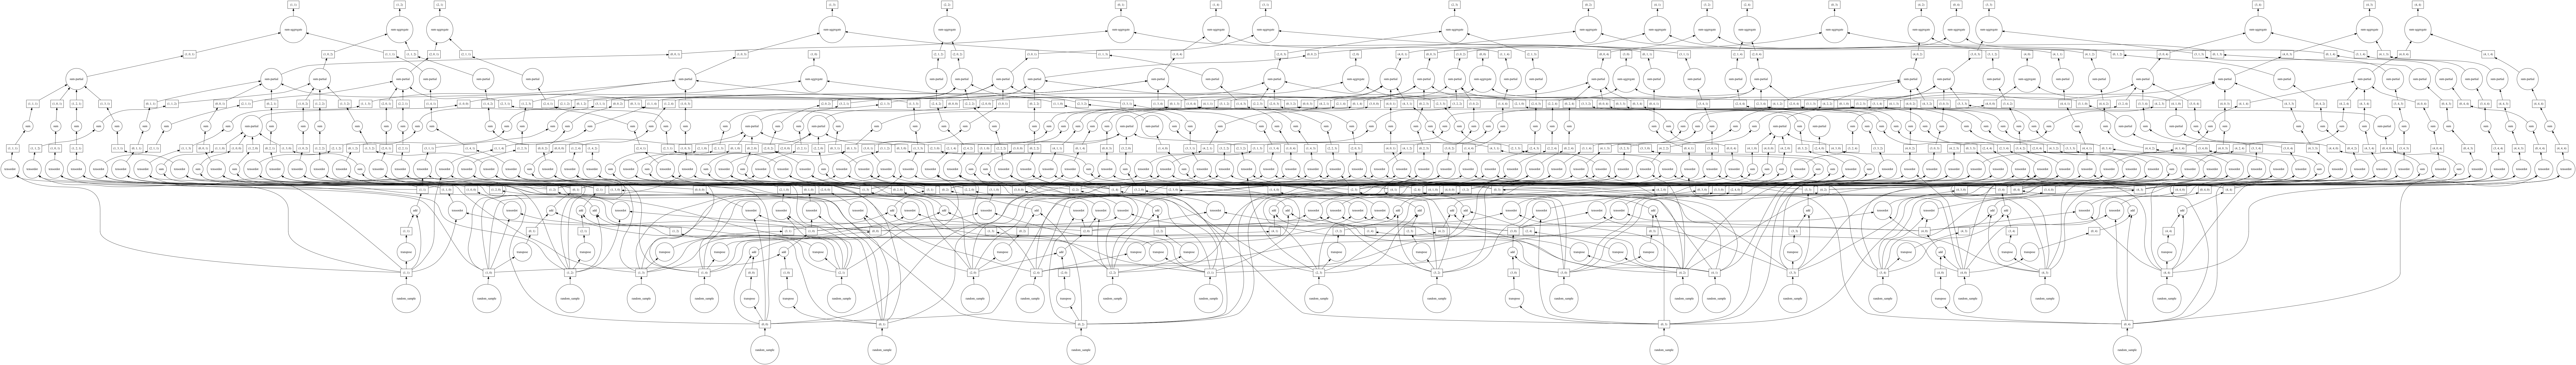

In [45]:
newda.visualize()

## Limitations

Of course there are limitations to what one can do. For example, most linear algebra functions are not dask compatible:

In [46]:
myarray = da.random.random((10,10))

eigenval, eigenvect = np.linalg.eig(myarray);

/Users/gw18g940/miniconda3/envs/dask_course/lib/python3.8/site-packages/dask/array/core.py:1352: FutureWarning: The `numpy.linalg.eig` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


The result is not a dask array:

In [47]:
eigenval

array([ 5.12341129+0.j        ,  0.22554346+0.87742726j,
        0.22554346-0.87742726j,  0.42586556+0.08064831j,
        0.42586556-0.08064831j, -0.28520438+0.46464166j,
       -0.28520438-0.46464166j, -0.6674443 +0.j        ,
       -0.19120987+0.j        , -0.26244405+0.j        ])

Also some operations such as those reshaping arrays may pose difficulties to Dasks as they require reshuffling array chunks. For example:

In [48]:
myarray = da.zeros((5000,5000))

In [49]:
myarray

dask.array<zeros, shape=(5000, 5000), dtype=float64, chunksize=(2500, 2500), chunktype=numpy.ndarray>

This works because it's easy to reshuffle some chunks:

In [50]:
reshaped = np.reshape(myarray,(5000,1000,5))

In [51]:
reshaped

dask.array<reshape, shape=(5000, 1000, 5), dtype=float64, chunksize=(2500, 500, 5), chunktype=numpy.ndarray>

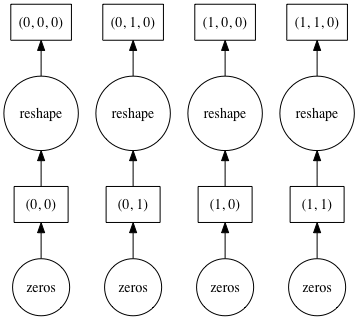

In [52]:
reshaped.visualize()

But this doesn't:

In [53]:
reshaped = np.reshape(myarray,(1000,5000,5))

ValueError: Shapes not compatible

While it actually works in numpy:

In [54]:
numpy_array = np.zeros((5000,5000))

In [55]:
reshaped = np.reshape(numpy_array,(1000,5000,5))

In [56]:
reshaped.shape

(1000, 5000, 5)

## Exercise

Try to solve this exercise. Regularly check the visual representation of arrays and of the task-graph to understand what is going on.

1. Create a dask-array of of normally distributed values with mean=9, and sigma = 1 of size 5000x5000
2. Add to it a **numpy** array of the same size and filled with ones. What kind of array to you obtain ? 
3. Use numpy-style indexing to recover only the values smaller than 10
4. Can you find how to create a dask-histogram of those values?
5. Compute the histogram and try to plot the result using matplotlib